# autoTS: Spectral Analysis template

This notebook describes a workflow for spectral analysis. It can be used as a template for similar analysis. Each cell represents a worflow component (input not written to disk). 

**Table of contents**
* Generating Data
* Pre-processing
    * Standardization
    * Detrend
    * Detect outliers
    * Remove outliers
    * Hypothesize over missing values
* Analysis
    * Spectral analysis
    * Significance testing 
* Visualization
    * Periodogram
    
Functions are available through the [Pyleoclim package](https://github.com/LinkedEarth/Pyleoclim_util/tree/Development) on the development branch.

In [1]:
import pyleoclim as pyleo

## Data Generation

Here,we use synthetic timeseries for demonstration purposes. 

Pyleoclim is being extended to handle LiPD files directly. For other types of data, Pyleoclim's basic object is Series, which will need to be created as a first step.

### Step 1: Generate a signal with trend, noise and missing values

This step would be replaced by opening dataset.

Text(0, 0.5, 'Value')

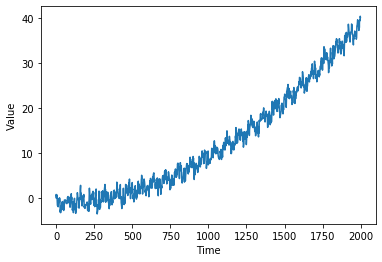

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a mixed signal with known frequencies
freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

# Add outliers

#outliers_start = np.mean(signal)+5*np.std(signal)
#outliers_end = np.mean(signal)+7*np.std(signal)
#outlier_values = np.arange(outliers_start,outliers_end,0.1)
#index = np.random.randint(0,len(signal),6)
#signal_out = signal
#for i,ind in enumerate(index):
#    signal_out[ind] = outlier_values[i]

# Add a non-linear trend
slope = 1e-5
intercept = -1
nonlinear_trend = slope*time**2 + intercept
signal_trend = signal + nonlinear_trend
#signal_trend = signal_out + nonlinear_trend

#Add white noise
sig_var = np.var(signal)
noise_var = sig_var / 2 #signal is twice the size of noise
white_noise = np.random.normal(0, np.sqrt(noise_var), size=np.size(signal))
signal_noise = signal_trend + white_noise

#Remove data points
del_percent = 0.4
n_del = int(del_percent*np.size(time))
deleted_idx = np.random.choice(range(np.size(time)), n_del, replace=False)
time_unevenly =  np.delete(time, deleted_idx)
signal_unevenly =  np.delete(signal_noise, deleted_idx)


#Plot
plt.plot(time_unevenly,signal_unevenly)
plt.xlabel('Time')
plt.ylabel('Value')

### Step 2: Create a series object for Pyleoclim

In [3]:
ts = pyleo.Series(time=time_unevenly,value=signal_unevenly)
ts

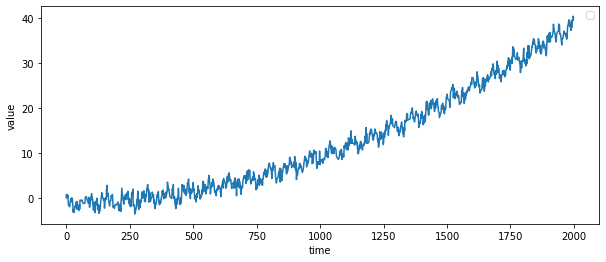

In [4]:
fig,ax = ts.plot()

## Preprocessing

### Standarize

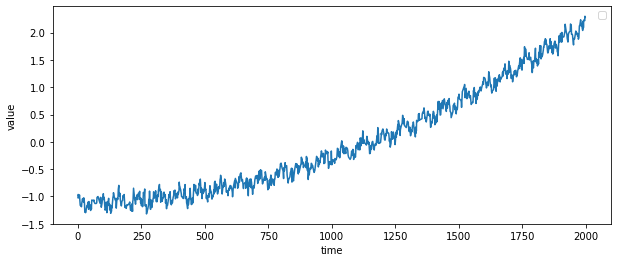

In [5]:
ts_std = ts.standardize()
fig,ax = ts_std.plot()

### Detrend

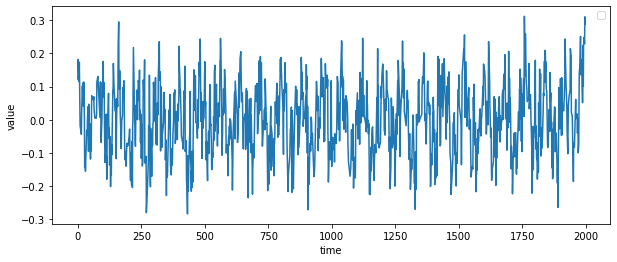

In [6]:
ts_detrended = ts_std.detrend(method='emd')
fig,ax = ts_detrended.plot()

### Detect outliers

Based on the detected outliers, may need to remove them prior to analysis

In [7]:
is_outlier = ts_detrended.detect_outliers()
np.where(is_outlier==True)

(array([], dtype=int64),)

### Remove outliers

**Rule**: if the outliers are more than 4 standard deviations away from the mean of the series, remove them. 

### Interpolation

This example uses a linear interpolation, other methods to achieve an evenly-spaced time series are spline interpolation, binning, and singular spectrum analysis. All methods could be equally valid and should be explored.

**Rule**: if the method spectral analysis is 'Lomb-Scargle' or 'WWZ', this step should be skipped (or same timeseries returned); else, this step is necessary. 

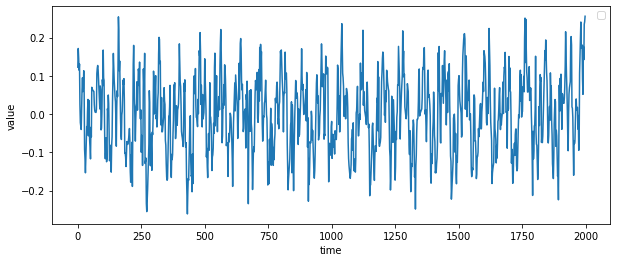

In [8]:
ts_interp = ts_detrended.interp(method='linear')
fig,ax = ts_interp.plot()

### Analysis

### Spectral Analysis
#### WWZ

This method doesn't require require evenly-spaced data in time, and therefore  uses the detrended time series.

In [9]:
%%time
psd_wwz = ts_detrended.spectral(settings={'method': 'Kirchner_f2py'})

CPU times: user 16.5 s, sys: 28.6 ms, total: 16.6 s
Wall time: 2.23 s


This method requires evenly-spaced data in time, and therefore uses the interpreted time series.

In [10]:
psd_mtm = ts_interp.spectral(method='mtm')

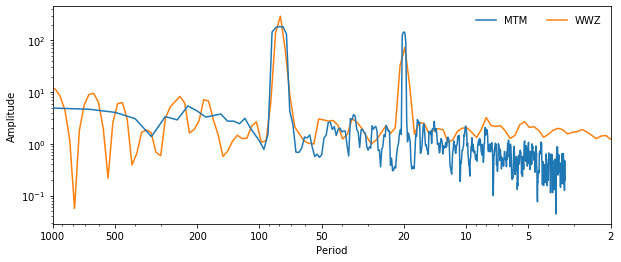

In [11]:
fig,ax = psd_mtm.plot(label='MTM', mute=True, zorder=99)
ax =  psd_wwz.plot(label='WWZ',ax=ax, lgd_kwargs={'ncol': 2})

### Significance testing

The idea behind significance testing is to create surrogate timeseries that could mimic an expected process  in the system (eg. AR1) and test whether the observed peaks could be explained by chance. 

In [12]:
psd_mtm_signif = psd_mtm.signif_test(qs=[0.95])

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [00:07<00:00, 28.23it/s]


In [13]:
psd_wwz_signif = psd_wwz.signif_test(qs=[0.95])

Performing spectral analysis on surrogates: 100%|██████████| 200/200 [07:32<00:00,  2.24s/it]


## Visualization

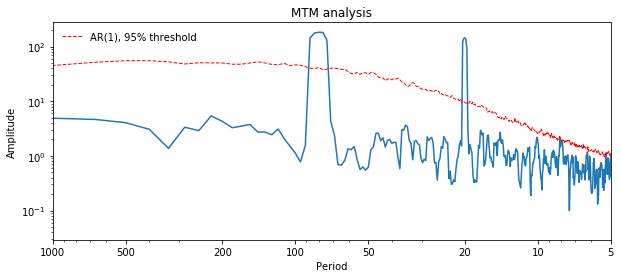

In [15]:
fig, ax = psd_mtm_signif.plot(title='MTM analysis')

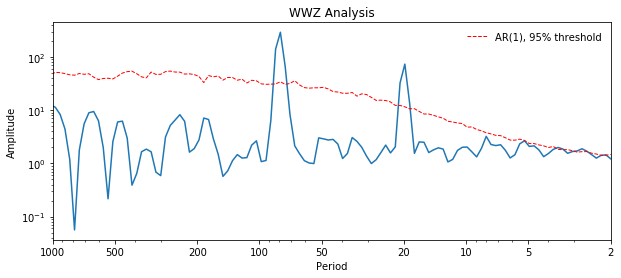

In [16]:
fig, ax = psd_wwz_signif.plot(title='WWZ Analysis')